In [1]:
import numpy as np
import pdb

from functools import reduce
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [2]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest

sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 10000

## Generate observed data

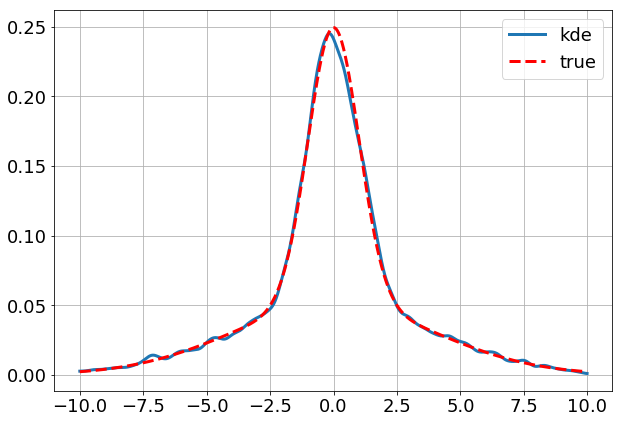

In [4]:
z = rnd.uniform(0,1, n) > 0.5

x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)).reshape(-1,1)

# check
fig = plt.figure(figsize=(10,7))
u = np.arange(-10,10,0.01).reshape(-1,1)

x_density = kd(bandwidth=0.2).fit(x)
x_density_samples = np.exp(x_density.score_samples(u))
plt.plot(u, x_density_samples, label='kde')

px = 0.5*(norm.pdf(u,0,sigma0)+norm.pdf(u,0,sigma1))
plt.plot(u, px, label='true', c='r', linestyle = '--')

plt.legend()
plt.grid()

## NCE objective function 

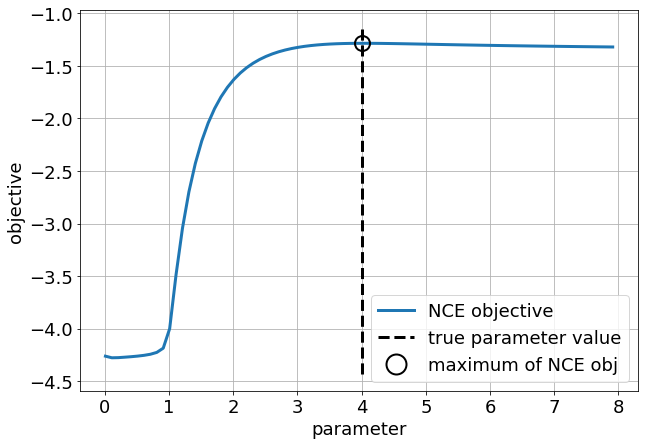

In [5]:
# nu is the ratio of noise to data samples
nu = 1

thetas = np.arange(0.01, 8, 0.1)

# correctly normalised model
pm = lambda u, theta: 0.5*(norm.pdf(u,0,theta)+norm.pdf(u, 0, sigma1))

pn = lambda u: norm.pdf(u,0, sigma0) # noise that matches the larger std

h = lambda u, theta: np.log(pm(u, theta)/pn(u)) # quick hack: generally better to work in log domain!

y = sigma0 * rnd.randn(n*nu)

n_theta = len(thetas)
J = np.zeros(n_theta)

for k in range(n_theta):
    theta_k = thetas[k]
    J[k] = -np.mean( np.log(1 + nu*np.exp(-h(x,theta_k))) ) - nu* np.mean( np.log(1 + 1/nu*np.exp(h(y,theta_k))) )


fig = plt.figure(figsize=(10,7))

plt.plot(thetas,J, label='NCE objective')
plt.plot(sigma0*np.array([1, 1]), plt.get(fig.gca(),'ylim'),'k--', label='true parameter value')

index = np.argmax(J)
plt.plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj')

plt.xlabel('parameter')
plt.ylabel('objective')

plt.grid()
lgd = plt.legend(loc='best', numpoints=1)
lgd.legendHandles[2]._legmarker.set_markersize(20)

## First lower bound

In [7]:
eps = 10**-15

#q0 = lambda u, alpha:  1 / (1 + (alpha/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/alpha**2)))
q0 = lambda u, alpha: norm.pdf(u, 0, alpha) / (norm.pdf(u, 0, alpha) + norm.pdf(u, 0, sigma1))
q1 = lambda u, alpha: 1 - q0(u, alpha) 

phi0 = lambda u, theta:  0.5*norm.pdf(u, 0, theta)
phi1 = lambda u, theta:  0.5*norm.pdf(u, 0, sigma1)

r0 = lambda u, theta, alpha: phi0(u, theta)/( q0(u, alpha)*pn(u) + eps)
r1 = lambda u, theta, alpha: phi1(u, theta)/( q1(u, alpha)*pn(u) + eps)
r = lambda u, z, theta, alpha: (z==0)*r0(u, theta, alpha) + (z==1)*r1(u, theta, alpha)

In [8]:
def compute_J1(x, y, zx, zy, theta, alpha):
    # compute expectation for 2nd term of J1
    #m = q0(y,alpha)*r0(y,theta, alpha) + q1(y, alpha)*r1(y,theta, alpha)

    # J1 objective
    J1 = -np.mean(np.log(1 + (nu/(r(x, zx, theta, alpha) + eps)))) \
         - nu*np.mean( np.log(1 + (1/nu)*r(y, zy, theta, alpha)))
         #- nu*np.mean( np.log(1 + (1/nu)*m)) 
    return J1

In [9]:
J1 = np.zeros(n_theta)
J1_sigma0 = np.zeros(n_theta)

for k in range(n_theta):
    theta_k = thetas[k]
    
    # generate 'missing data' using variational q distribution
    zx = rnd.uniform(0, 1, n) < q1(x, theta_k) # shape (n, n)
    zy = rnd.uniform(0, 1, n) < q1(y, theta_k)
    zx_2 = rnd.uniform(0, 1, n) < q1(x, sigma0)
    zy_2 = rnd.uniform(0, 1, n) < q1(y, sigma0)
    
    # compute two types of lower bound
    J1[k] = compute_J1(x, y, zx, zy, theta_k, theta_k)
    J1_sigma0[k] = compute_J1(x, y, zx_2, zy_2, theta_k, sigma0)

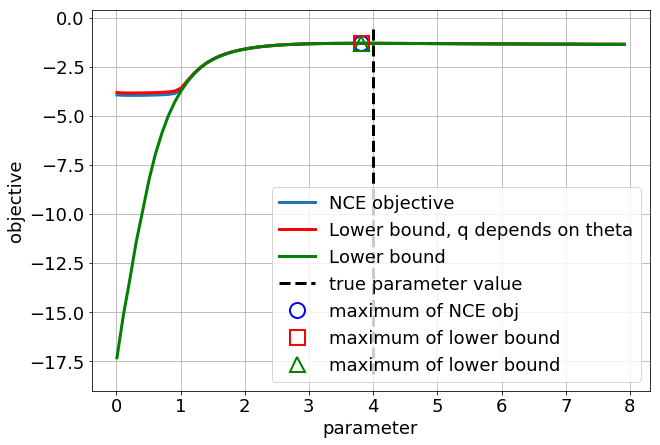

In [10]:
fig = plt.figure(figsize=(10, 7))
plt.plot(thetas, J, label='NCE objective')
plt.plot(thetas, J1, 'r', label='Lower bound, q depends on theta')
plt.plot(thetas, J1_sigma0, 'g', label='Lower bound')

# true param value
plt.plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of NCE obj
plt.plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')

index1 = np.argmax(J1)
# maximiser of lower bound
plt.plot(thetas[index1], J1[index1], 'rs', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='r', linestyle='none', label='maximum of lower bound')

index2 = np.argmax(J1_sigma0)
# maximiser of lower bound
plt.plot(thetas[index2], J1[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='maximum of lower bound')

"""
plt.plot(theta,Jlower,'g', label='lb w/o importance sampling')
index2 = np.argmax(Jlower)
# maximiser of lower bound (before importance sampling)
plt.plot(theta[index2], Jlower[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='max of lb w/o importance sampling')
"""

plt.xlabel('parameter')
plt.ylabel('objective')
plt.legend(loc='lower right', numpoints=1)
plt.grid()

In [11]:
print('J1 is a numerical lower bound for {}% of the parameters'.format(100* np.sum(J1_sigma0 < J) / J.size))

J1 is a numerical lower bound for 90.0% of the parameters


## Using EM-type procedure to maximize J1

For a simple initial experiment, we will iterate between optimising $\theta$ (for a fixed q) to obtain $\theta_k$, and then resetting q to be:

$$ q_k := q(z=0 \ | \ u; \theta_k) = \left(  1 + \frac{\theta_k}{\sigma_1} \exp \left(\frac{- u^2}{2} \left( \frac{1}{\sigma_1^2} - \frac{1}{\theta_k^2} \right) \right) \right)^{-1} $$

Optimising $\theta$ involves maximising the lower bound on the NCE objective:

\begin{align}
J_1^k(\theta) = \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \left[ \log(1 + \frac{\nu}{r(x, z; \theta)}) \right]} - \color{blue}{ \nu \mathbb{E}_{y}  \left[ \log(1 + \frac{1}{\nu} \mathbb{E}_{z \sim q_k}[r(y, z; \theta)] ) \right]}
\end{align}

where 

$$ r(u,z, \theta) = \frac{\phi(u, z; \theta)}{q_k(z \ | \ u) p_y(u)}$$


Note that q here is *not* a function of theta.

To find the argmax of $J_1^K(\theta)$, we need to differentiate it. To do so, let us first further reduce the notational burden, by writing:

\begin{align}
J_1^k(\theta) & =  \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \left[ \log(\psi_1(x, z; \theta)) \right]} -       \color{blue}{ \nu \mathbb{E}_{y}  \left[  \log(\psi_2(y; \theta)) \right]} \\
\end{align}

Where the terms of the same colour are equivalent to each other.

Now, let us take derivative with respect to $\theta$:

\begin{align}
\color{red}{ \nabla_{\theta} \log(\psi_1(x, z; \theta))} & = \frac{1}{\psi_1(x, z; \theta)} \nabla_{\theta} \psi_1(x, z; \theta) \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \nabla_{\theta} r(x, z; \theta) \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \frac{\nabla_{\theta} \phi(x, z; \theta)}{q_k(z \ | \ x)p_y(x)}
\end{align}

Hence, we need:

\begin{align}
\nabla_{\theta} \phi(x, z; \theta) & = \nabla_{\theta} \exp ( \log ( \phi(x, z; \theta) ) ) \\
& = \left[ \nabla_{\theta} \log(\phi(x, z; \theta)) \right] \exp ( \log ( \phi(x, z; \theta) ) )\\
& = \left[ \nabla_{\theta} \left(-\log(\theta) - \frac{x^2}{2 \theta^2} \right) \right] \phi(x, z; \theta) \\
& = \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \phi(x, z; \theta)
\end{align}

Plugging this back in, we get:

\begin{align}
\color{red}{ \nabla_{\theta} \log(\psi_1(x, z; \theta))} & = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \frac{\left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \phi(x, z; \theta)}{q_k(z \ | \ x)p_y(x)} \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \\
& = \color{red}{-\nu \frac{\psi_1(x, z; \theta) - 1}{\psi_1(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right]} \\
\end{align}

Where in the final line we used the fact that $\color{red}{\psi_1(x, z; \theta) - 1 = \frac{1}{r(x, z; \theta)}}$.

Now we find the derivative of the second (blue) term of $J_1^K(\theta)$. Recalling that $\color{blue}{\psi_2(y; \theta) = 1 + \frac{1}{\nu} \mathbb{E}_{z \sim q_k}[r(y, z; \theta)]}$, we have:

\begin{align}
\color{blue}{\nabla_{\theta} \log(\psi_2(y; \theta))} & = \frac{1}{\psi_2(y; \theta)} \nabla_{\theta} \psi_2(y; \theta) \\
& = \frac{1}{\psi_2(y; \theta)} \frac{1}{\nu} \mathbb{E}_{z \sim q_k} \left[ \frac{\nabla_{\theta} \phi(y, z; \theta)}{q_k(z \ | \ y)p_y(y)} \right] \\
& = \frac{1}{\psi_2(y; \theta)} \frac{1}{\nu} \mathbb{E}_{z \sim q_k} \left[ r(y, z; \theta) \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right] \right] \\
& = \color{blue}{\frac{\psi_2(y; \theta) - 1}{\psi_2(y; \theta)} \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right]}
\end{align}

Putting this all together, we arrive at: 

\begin{align}
\nabla_{\theta}(J_1^k(\theta)) & =  \color{red}{\nu \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \frac{\psi_1(x, z; \theta) - 1}{\psi_1(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right]} + \color{blue}{ -\nu \mathbb{E}_{y}  \frac{\psi_2(y; \theta) - 1}{\psi_2(y; \theta)} \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right]} \\
\end{align}

In [12]:
def psi_1(x, z, theta, alpha):
    return 1 + (1 / r(x, z, theta, alpha))

def psi_2(y, z, theta, alpha):
    return 1 + (1/nu)*r(y, zy, theta, alpha)

In [13]:
def J1_grad(x, y, zx, zy, theta, alpha):
    '''Computes J1_grad as defined in the equations above. NOTE: we use a 1-sample MC estimate
    for the expectation w.r.t to q'''
    
    term_1 = nu*np.mean(((psi_1(x, zx, theta, alpha) - 1)/psi_1(x, zx, theta, alpha))*(-(1/theta) + (x**2/theta**3)))
    term_2 = -nu*np.mean(((psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha))*(-(1/theta) + (y**2/theta**3)))
    
    return term_1 + term_2

In [14]:
opt_thetas = []
J1s = []

theta_k = np.array([1])
opt_thetas.append(theta_k)
J1s.append(compute_J1(x, y, zx, zy, theta_k[0], theta_k))

prev_J1 = -999
current_J1 = -9999

while np.abs(prev_J1 - current_J1) > 10**-6:
    # sample from q(z|x) and q(z|y)
    zx = rnd.uniform(0,1, n) < q1(x, theta_k)
    zy = rnd.uniform(0,1, n) < q1(y, theta_k)
    
    J1_k = lambda theta: compute_J1(x, y, zx, zy, theta[0], theta_k)
    J1_k_neg = lambda theta: -J1_k(theta)
    
    J1_k_grad = lambda theta: np.array([J1_grad(x, y, zx, zy, theta[0], theta_k)])
    J1_k_grad_neg = lambda theta: -J1_k_grad(theta)
    
    res = minimize(J1_k_neg, theta_k, method='BFGS', jac=J1_k_grad_neg,
                   options={'disp': True})
    
    prev_J1 = J1_k(theta_k)
    theta_k = res.x
    current_J1 = J1_k(theta_k)
    
    # store results
    opt_thetas.append(theta_k)
    J1s.append(current_J1)

opt_thetas = np.array(opt_thetas).flatten()
J1s = np.array(J1s)

         Current function value: 2.541844
         Iterations: 9
         Function evaluations: 122
         Gradient evaluations: 110
         Current function value: 1.292942
         Iterations: 5
         Function evaluations: 52
         Gradient evaluations: 40
         Current function value: 1.289552
         Iterations: 3
         Function evaluations: 93
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 1.289343
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 1.289344
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [15]:
opt_thetas, J1s

(array([1.        , 3.25582507, 3.94168354, 4.1074588 , 4.12240891,
        4.12240891]),
 array([-3.88719903, -1.39735962, -1.28985074, -1.2893506 , -1.28934449,
        -1.28934449]))

Above, we (hopefully) generated successively better lower bounds to the NCE objective function. Let's evaluate these functions on a range of values and then plot them.

In [16]:
lower_bounds = [np.zeros(n_theta) for i in range(len(opt_thetas))]
for i in range(len(lower_bounds)):
    alpha = opt_thetas[i]
    
    # generate 'missing data' using variational q distribution
    zx = rnd.uniform(0, 1, n) < q1(x, alpha) # shape (n, n)
    zy = rnd.uniform(0, 1, n) < q1(y, alpha)
    
    for j in range(n_theta):
        # compute lower bound
        lower_bounds[i][j] = compute_J1(x, y, zx, zy, thetas[j], alpha)

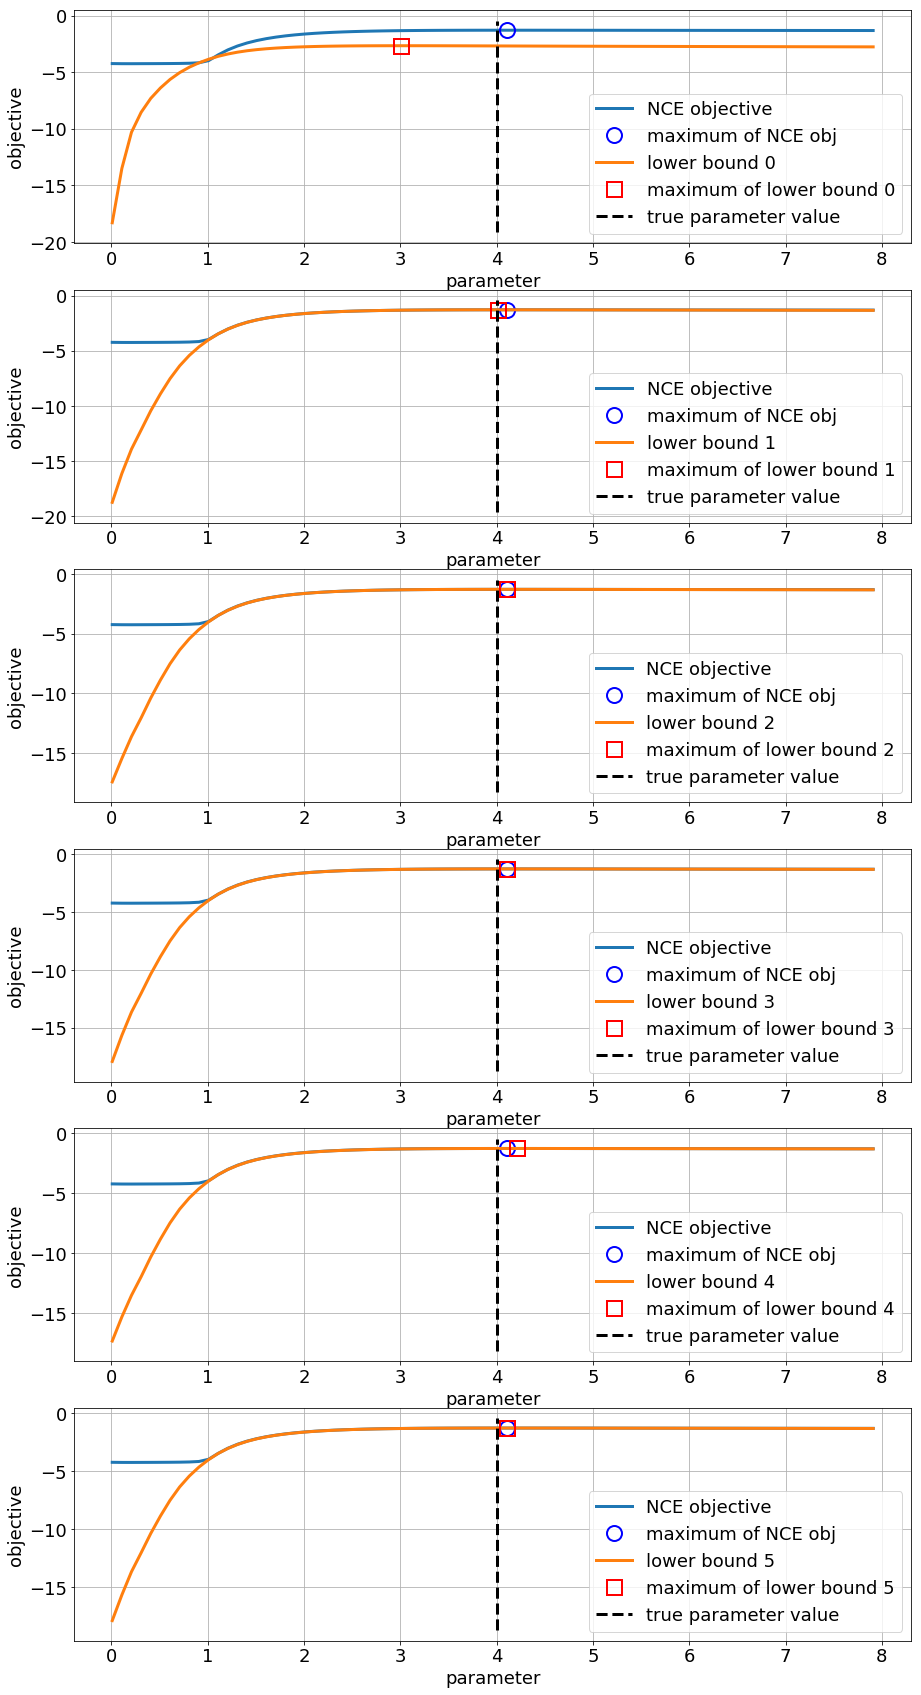

In [17]:
fig, axs = plt.subplots(len(lower_bounds), 1, figsize=(15, 30))
axs = axs.ravel()
for i in range(len(lower_bounds)):
    
    # plot NCE objective and its maximum
    axs[i].plot(thetas, J, label='NCE objective')
    axs[i].plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')
    
    lb = lower_bounds[i]
    axs[i].plot(thetas, lb, label='lower bound {}'.format(i))
   
    lb_index = np.argmax(lb)
    # maximiser of lower bound
    axs[i].plot(thetas[lb_index], lb[lb_index], 'rs', markersize=15, fillstyle='none', 
             markeredgewidth=2, linestyle='none', label='maximum of lower bound {}'.format(i))
    
    # true param value
    axs[i].plot(sigma0 * np.array([1,1]), plt.get(axs[i],'ylim'), 'k--', label='true parameter value')

    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()

## Using variational EM-type procedure to maximize J1

Now we try using a variational q distribution of the form:

$$ q(z=0 \ | \ u; \textbf{w}) = \sigma(\textbf{w}^T \tilde{\textbf{u}}) = \sigma(w_0 + w_1u + w_2u^2) $$

where $\sigma$ is the sigmoid function,  $\textbf{w}$ are the variational parameters and $\tilde{\textbf{u}} := (1, u, u^2)^T$. We will then alternate optimisation of $\theta$ and $\textbf{w}$ (i.e apply a form of coordinate ascent).

To optimise our objective function w.r.t to $\textbf{w}$, we need to find the gradient of:

\begin{align}
J_1^k(\textbf{w}) = \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q(z \ | \ u; \textbf{w})} \left[ \log(1 + \frac{\nu}{r(x, z; \textbf{w})}) \right]} - \color{blue}{ \nu \mathbb{E}_{y}  \left[ \log(1 + \frac{1}{\nu} \mathbb{E}_{z \sim q(z \ | \ u; \textbf{w})}[r(y, z; \textbf{w})] ) \right]}
\end{align}

where 

$$ r(u,z, \textbf{w}) = \frac{\phi(u, z; \theta_k)}{q_k(z \ | \ u; \textbf{w}) p_y(u)}$$

Note that this is a *stochastic* optimisation problem, since we are differentiating w.r.t to parameters of q, but there is an expectation over q. This complicates the situation.

Since q is a bernouilli distribution, we can analytically write down what the expectation is (as we do below) and then differentiate. For more complex distributions, we will need to use something else: perhaps a pathwise derivative estimator (http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) or score function estimator (http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/).

To calculate $\nabla_{\textbf{w}} J_1^k(\textbf{w})$, we first analytically evaluate the expectations. Doing this, we see that the blue term will no longer depend on q (since q was only introduced in the blue term for importance sampling, which we now undo). Hence, we only have to evaluate:

\begin{align}
\nabla_{\textbf{w}} J_1^k(\textbf{w}) & = \color{red}{\nabla_{\textbf{w}} \left[ -\mathbb{E}_x \sum_{i=1}^2 q(i \ | \ x; \textbf{w}) \log \left( 1 + \nu\frac{ q(i \ | \ x; \textbf{w}) p_y(x)}{\phi(x, i, \theta_k)} \right) \right]}
\end{align}

The gradient of a term inside the summation has the form:

\begin{align}
\nabla_{\textbf{w}} \left[ q_i(\textbf{w}) \log( 1 + a_iq_i(\textbf{w})) \right] = \left( \log( 1 + a_iq_i(\textbf{w})) + \frac{q_i(\textbf{w})}{1 + a_i q_i(\textbf{w})} \right) \nabla_{\textbf{w}} q_i(\textbf{w})
\end{align}

Where we have simplified notation by setting: $q_i(\textbf{w}) = q(i \ | \ x; \textbf{w})$ and $ a_i = \frac{p_y(x)}{\phi(x, i, \theta_k)}$.

Observe that 

$$\nabla_{\textbf{w}} q_1(\textbf{w}) =  \nabla_{\textbf{w}} \left[ 1 - q_0(\textbf{w}) \right] = - \nabla_{\textbf{w}} q_0(\textbf{w}) $$

and so our original gradient becomes:

\begin{align}
\nabla_{\textbf{w}} J_1^k(\textbf{w}) & = \color{red}{ -\mathbb{E}_x  \left( \log \left( \frac{ 1 + a_0q_0(\textbf{w})}{1 + a_1q_1(\textbf{w})} \right) + \frac{q_0(\textbf{w})}{1 + a_0 q_0(\textbf{w})} - \frac{q_1(\textbf{w})}{1 + a_1 q_1(\textbf{w})}  \right) \nabla_{\textbf{w}} q_0(\textbf{w})}
\end{align}

where, using the definition of $q$, we have:

\begin{align} 
\nabla_{\textbf{w}} q_0(\textbf{w}) & = \nabla_{\textbf{w}} q(z=0 \ | \ x; \textbf{w}) \\
& = \nabla_{\textbf{w}} \left[ \sigma(\textbf{w}^T \tilde{\textbf{x}}) \right] \\
& = \sigma(\textbf{w}^T \tilde{\textbf{x}}) (1 - \sigma(\textbf{w}^T \tilde{\textbf{x}})) \tilde{\textbf{x}}
\end{align}

In [22]:
degree = 3

In [23]:
def make_poly_design_matrix(u, deg):
    u = u.reshape(-1)
    U = np.zeros((len(u), deg))
    for i in range(deg):
        U[:, i] = u**i  
    return U

def sigmoid(u):
    return  1/(1 + np.exp(-u))

def q0_var(u, w):
    U = make_poly_design_matrix(u, degree)
    return sigmoid(np.dot(U,w))

In [24]:
q1_var = lambda u, w: 1 - q0_var(u, w)
r0_var = lambda u, theta, w: phi0(u, theta)/( q0_var(u, w)*pn(u) + eps)
r1_var = lambda u, theta, w: phi1(u, theta)/( q1_var(u, w)*pn(u) + eps)

In [378]:
def compute_J1_analytic(x, y, theta, w):
    '''Computes J1 by by analytically solving the expectations'''
    # first term
    first_term = -np.mean( (q0_var(x, w)* np.log(1 + (nu/(r0_var(x, theta, w) + eps)))) 
                 + (q1_var(x, w)* np.log(1 + (nu/(r1_var(x, theta, w) + eps)))) )      
    # second term
    m = q0_var(y, w)*r0_var(y, theta, w) + q1_var(y, w)*r1_var(y, theta, w)
    second_term = - nu*np.mean(np.log(1 + (1/nu)*m)) 
    
    return first_term  + second_term

In [214]:
def compute_J1_grad_w(x, theta, w):
    '''Computes J1's grad w.r.t w, as specified in the equations above'''
    x = x.reshape(-1)
    a0 = (pn(x)/(phi0(x, theta)) + eps)
    a1 = (pn(x)/(phi1(x, theta) + eps))
    
    A = np.log((1 + a0*q0_var(x, w))/(1 + a1*q1_var(x, w)))
    B = q0_var(x, w)/(1 + a0*q0_var(x, w))
    C = q1_var(x, w)/(1 + a1*q1_var(x, w))
    D = A + B - C
    
    X = make_poly_design_matrix(x, degree)
    q0_grad = X.T*(q0_var(x, w)*(1 - q0_var(x, w)))
    
    J1_grad = -np.mean(D*q0_grad, axis=1)
    
    return J1_grad

In [23]:
def psi_1_0(x, theta, w):
    return 1 + (1/ r0_var(x, theta, w))

def psi_1_1(x, theta, w):
    return 1 + (1/ r1_var(x, theta, w))

def psi_2_analytic(y, theta, w):
    return 1 + (1/nu)*(q0_var(x, w)*r0_var(y,theta, w) + q1_var(x, w)*r1_var(y,theta, w))

def compute_J1_grad_theta(x, y, theta, w):
    '''Computes J1_grad w.r.t theta analytically (no need to sample z's)'''
    A = q0_var(x, w)*((psi_1_0(x, theta, w) - 1)/psi_1_0(x, theta, w))
    B = q1_var(x, w)*((psi_1_1(x, theta, w) - 1)/psi_1_1(x, theta, w))
    C = A + B
    
    term_1 = nu*np.mean(C*(-(1/theta) + (x**2/theta**3)))
    term_2 = -nu*np.mean(((psi_2_analytic(y, theta, w) - 1)/psi_2_analytic(y, theta, w))*(-(1/theta) + (y**2/theta**3)))
    
    return term_1 + term_2

In [64]:
opt_ws = []  # one per EM step
opt_thetas = []  # one per EM step
J1s = []  # store all function evaluations of J1 during optimisation

# store num function evaluations needed during each step of the coordinate ascent
# i.e the number of evals before switching between optimising theta or w
switch_points = [] 

w_k = np.array([0.5,0.5,0.5])
theta_k = np.array([1])

opt_ws.append(w_k)
opt_thetas.append(theta_k)
J1s.append(compute_J1_analytic(x, y, theta_k[0], w_k))

prev_J1 = -999
current_J1 = -9999
num_em_steps = 0  # a 'step' is one optimisation w.r.t either theta or w

while np.abs(prev_J1 - current_J1) > 10**-6:    
    # optimise w.r.t variational parameters w    
    def J1_k_w(w):
        val = compute_J1_analytic(x, y, theta_k[0], w)
        J1s.append(val)
        return val
        
    J1_k_grad_w = lambda w: compute_J1_grad_w(x, theta_k[0], w)
           
    J1_k_w_neg = lambda w: -J1_k_w(w)
    J1_k_grad_w_neg = lambda w: -J1_k_grad_w(w)
    
    res_w = minimize(J1_k_w_neg, w_k, method='Nelder-Mead', options={'disp': True})
    #res_w = minimize(J1_k_w_neg, w_k, method='BFGS', jac=J1_k_grad_w_neg,
                    #options={'gtol': 1e-07, 'disp': True})
    
    w_k = res_w.x
    switch_points.append(res_w.nfev)
           
    # optimise w.r.t theta
    def J1_k(theta):
        val = compute_J1_analytic(x, y, theta[0], w_k)
        J1s.append(val)
        return val
    # !!! DELETE NP.ARRAY IF THETA IS LATER A VECTOR
    J1_k_grad = lambda theta: np.array([compute_J1_grad_theta(x, y, theta[0], w_k)]) 
    
    J1_k_neg = lambda theta: -J1_k(theta)
    J1_k_grad_neg = lambda theta: -J1_k_grad(theta)
    
    res_theta = minimize(J1_k_neg, theta_k, method='Nelder-Mead', options={'disp': True})
    #res_theta = minimize(J1_k_neg, theta_k, method='BFGS', jac=J1_k_grad_neg,
                        #options={'gtol': 1e-07, 'disp': True})
    
    switch_points.append(res_theta.nfev)
    prev_J1 = J1_k(theta_k)
    theta_k = res_theta.x
    current_J1 = J1_k(theta_k)
    
    # store results
    opt_ws.append(w_k)
    opt_thetas.append(theta_k)
    num_em_steps += 2

opt_thetas = np.array(opt_thetas).flatten()
J1s = np.array(J1s)

Optimization terminated successfully.
         Current function value: 3.887199
         Iterations: 131
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 2.653900
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 2.653900
         Iterations: 1
         Function evaluations: 4
Optimization terminated successfully.
         Current function value: 2.653900
         Iterations: 12
         Function evaluations: 24


In [65]:
J1s.shape, switch_points

((304,), [233, 38, 4, 24])

### Plot values of J1 during training

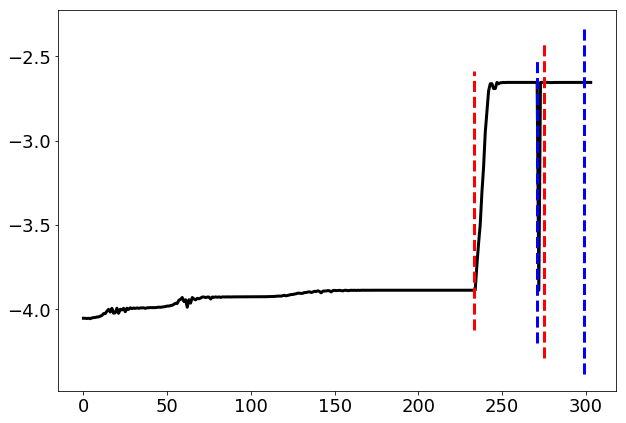

In [66]:
switch_poins_cum = [sum(switch_points[:i+1]) for i in range(len(switch_points))]
fig, axs = plt.subplots(1,1, figsize=(10,7))

t = np.arange(len(J1s))
axs.plot(t, J1s, c='k')
for i in range(len(switch_points)):
    if i % 2 == 0:
        axs.plot(switch_poins_cum[i]*np.array([1,1]), plt.get(axs, 'ylim'), 'r--')
    else:
        axs.plot(switch_poins_cum[i]*np.array([1,1]), plt.get(axs, 'ylim'), 'b--')

In [85]:
np.log(3)

1.0986122886681098

In [67]:
opt_thetas, opt_ws

(array([1.        , 2.90576172, 2.90576172]),
 [array([0.5, 0.5, 0.5]),
  array([ 1.95375845e-05, -7.70962011e-06, -9.62662587e-07]),
  array([ 2.05144637e-05, -7.70962011e-06, -9.62662587e-07])])

In [82]:
lower_bounds = [np.zeros(n_theta) for i in range(int(num_em_steps/2)+1)]
for i in range(int(num_em_steps/2)+1):
    w = opt_ws[i]
    for j in range(n_theta):
        # compute lower bound
        lower_bounds[i][j] = compute_J1_analytic(x, y, thetas[j], w)

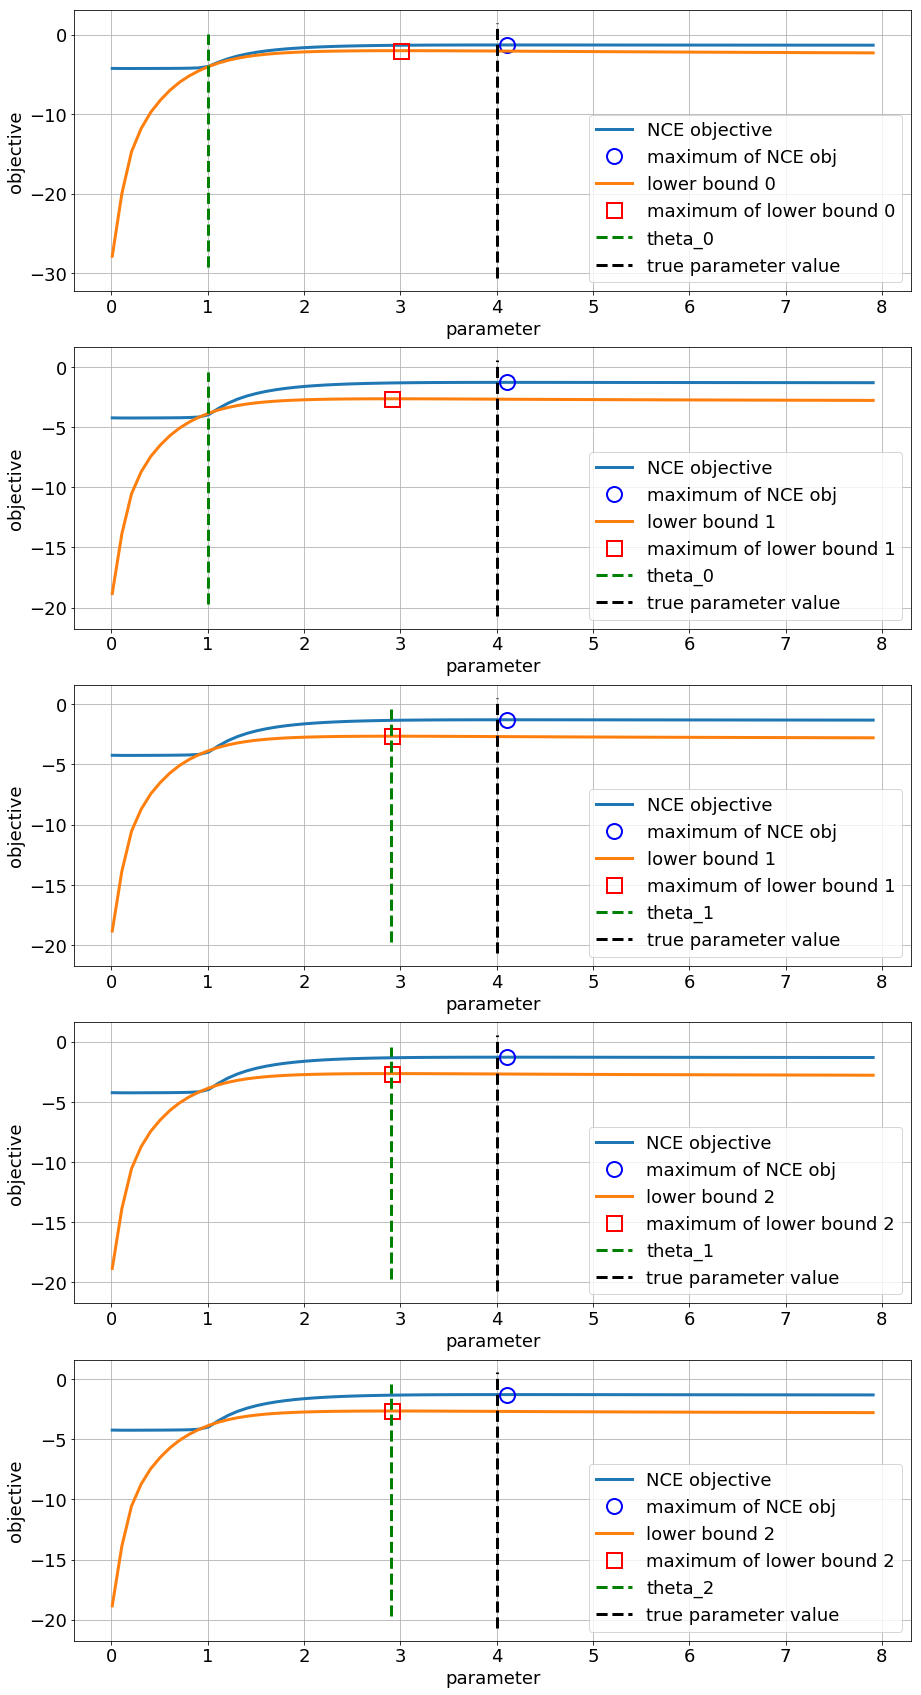

In [84]:
fig, axs = plt.subplots(num_em_steps+1, 1, figsize=(15, 30))
axs = axs.ravel()

for i in range(num_em_steps+1):
    # plot NCE objective and its maximum
    axs[i].plot(thetas, J, label='NCE objective')
    axs[i].plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')
    
    lb = lower_bounds[int(np.ceil(i/2))]
    axs[i].plot(thetas, lb, label='lower bound {}'.format(int(np.ceil(i/2))))
   
    lb_index = np.argmax(lb)
    # maximiser of lower bound
    axs[i].plot(thetas[lb_index], lb[lb_index], 'rs', markersize=15, fillstyle='none', 
             markeredgewidth=2, linestyle='none', label='maximum of lower bound {}'.format(int(np.ceil(i/2))))
    
    # current theta value
    axs[i].plot(opt_thetas[int(i/2)] * np.array([1,1]),
                plt.get(axs[i],'ylim'), 'g--', label='theta_{}'.format(int(i/2)))
    # true param value
    axs[i].plot(sigma0 * np.array([1,1]), plt.get(axs[i],'ylim'), 'k--', label='true parameter value')

    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()

In [80]:
opt_ws

[array([0.5, 0.5, 0.5]),
 array([ 1.95375845e-05, -7.70962011e-06, -9.62662587e-07]),
 array([ 2.05144637e-05, -7.70962011e-06, -9.62662587e-07])]

In [81]:
num_em_steps

4

# debugging

In [36]:
eps = 10**-15

#q0 = lambda u, alpha:  1 / (1 + (alpha/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/alpha**2)))
q0 = lambda u, alpha: norm.pdf(u, 0, alpha) / (norm.pdf(u, 0, alpha) + norm.pdf(u, 0, sigma1))
q1 = lambda u, alpha: 1 - q0(u, alpha) 

phi0 = lambda u, theta:  0.5*norm.pdf(u, 0, theta)
phi1 = lambda u, theta:  0.5*norm.pdf(u, 0, sigma1)

r0 = lambda u, theta, alpha: phi0(u, theta)/( q0(u, alpha)*pn(u) + eps)
r1 = lambda u, theta, alpha: phi1(u, theta)/( q1(u, alpha)*pn(u) + eps)
r = lambda u, z, theta, alpha: (z==0)*r0(u, theta, alpha) + (z==1)*r1(u, theta, alpha)

In [37]:
def compute_J1(x, y, zx, zy, theta, alpha):
    first_term = -np.mean(np.log(1 + (nu/(r(x, zx, theta, alpha) + eps))))
    second_term = -nu*np.mean( np.log(1 + (1/nu)*r(y, zy, theta, alpha)))
    return first_term, second_term

In [38]:
degree = 3

def make_poly_design_matrix(u, deg):
    u = u.reshape(-1)
    U = np.zeros((len(u), deg))
    for i in range(deg):
        U[:, i] = u**i  
    return U

def sigmoid(u):
    return  1/(1 + np.exp(-u))

def q0_var(u, w):
    U = make_poly_design_matrix(u, degree)
    return sigmoid(np.dot(U,w))

q1_var = lambda u, w: 1 - q0_var(u, w)
r0_var = lambda u, theta, w: phi0(u, theta)/( q0_var(u, w)*pn(u) + eps)
r1_var = lambda u, theta, w: phi1(u, theta)/( q1_var(u, w)*pn(u) + eps)

In [39]:
def compute_J1_analytic(x, y, theta, w):
    '''Computes J1 by by analytically solving the expectations'''
    
    # first term
    a0 = nu/(r0_var(x, theta, w) + eps)
    a1 = nu/(r1_var(x, theta, w) + eps)
    first_term = -np.mean(q0_var(x, w)*np.log(1 + a0) + q1_var(x, w)*np.log(1 + a1))      
    
    # second term
    m = q0_var(y, w)*r0_var(y, theta, w) + q1_var(y, w)*r1_var(y, theta, w)
    second_term = - nu*np.mean(np.log(1 + (1/nu)*m)) 
    
    return  first_term, second_term

In [40]:
thetas_small = thetas[::2]
thetas_small
n_theta_small = len(thetas_small)

In [41]:
J1s_mc_1 = np.zeros(n_theta_small)
J1s_mc_2 = np.zeros(n_theta_small)

J1s_analytic_1 = np.zeros(n_theta_small) 
J1s_analytic_2 = np.zeros(n_theta_small) 

In [42]:
alpha = 4
for i in range(n_theta_small):
    theta = thetas_small[i]
    #zx = np.zeros((n, n))
    #zy = np.zeros((n, n))
    #for j in range(n):
        #zx[i,:] = rnd.uniform(0, 1, n) < q1(x[j], alpha)
        #zy[i,:] = rnd.uniform(0, 1, n) < q1(y[j], alpha)  
    zx = rnd.uniform(0, 1, n) < q1(x, alpha)
    zy = rnd.uniform(0, 1, n) < q1(y, alpha)  
    w = np.array([-np.log(alpha), 0, (1/2)*(1-alpha**(-2))])
    
    #print(np.allclose(q0_var(x, w), q0(x, alpha).reshape(-1)))
    #print(compute_J1(x, y, Zx, Zy, theta, alpha), compute_J1_analytic(x, y, theta, w))
    
    J1s_mc_1[i], J1s_mc_2[i] = compute_J1(x, y, zx, zy, theta, alpha)
    J1s_analytic_1[i], J1s_analytic_2[i] = compute_J1_analytic(x, y, theta, w)

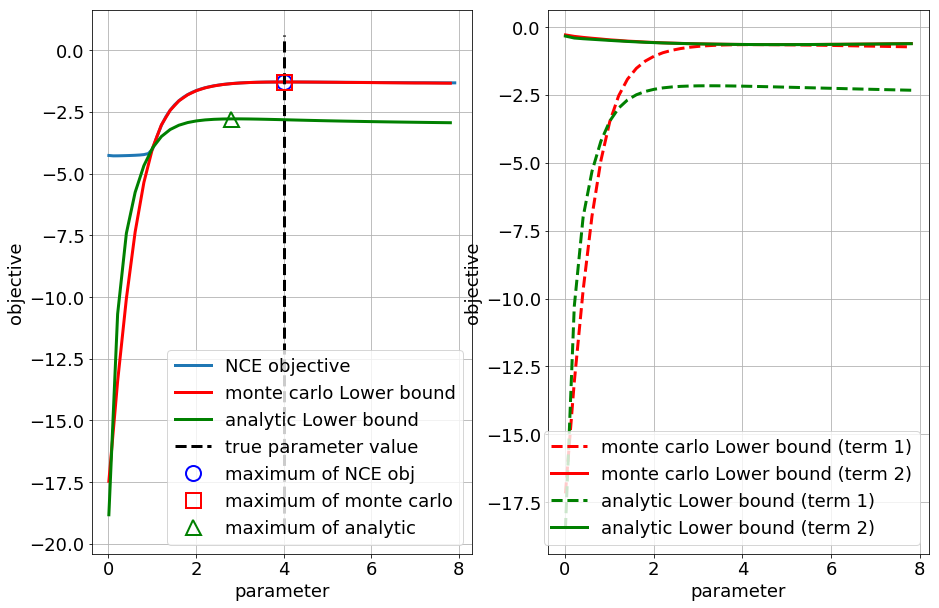

In [51]:
J1s_mc = J1s_mc_1+J1s_mc_2
J1s_analytic = J1s_analytic_1+J1s_analytic_2

fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs = axs.ravel()
axs[0].plot(thetas, J, label='NCE objective')
axs[1].plot(thetas_small, J1s_mc_1, 'r--', label='monte carlo Lower bound (term 1)')
axs[1].plot(thetas_small, J1s_mc_2, 'r', label='monte carlo Lower bound (term 2)')
axs[1].plot(thetas_small, J1s_analytic_1, 'g--', label='analytic Lower bound (term 1)')
axs[1].plot(thetas_small, J1s_analytic_2, 'g', label='analytic Lower bound (term 2)')
axs[0].plot(thetas_small, J1s_mc, 'r', label='monte carlo Lower bound')
axs[0].plot(thetas_small, J1s_analytic, 'g', label='analytic Lower bound')

# true param value
axs[0].plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of NCE obj
axs[0].plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')

index1 = np.argmax(J1s_mc)
# maximiser of lower bound
axs[0].plot(thetas_small[index1], J1s_mc[index1], 'rs', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='r', linestyle='none', label='maximum of monte carlo')

index2 = np.argmax(J1s_analytic)
# maximiser of lower bound
axs[0].plot(thetas_small[index2], J1s_analytic[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='maximum of analytic')
for i in range(2):
    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()